In [1]:
import pandas as pd
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split

# Load and preprocess 'data'
data = pd.read_csv('featured_data_fullpack.csv')
data['date'] = pd.to_datetime(data['date'])

# Load and preprocess 'vix_data'
vix_data = pd.read_csv('dataset\^VIX.csv')
vix_data = vix_data.rename(columns={"Date": "date"})
vix_data['date'] = pd.to_datetime(vix_data['date'])  # Convert to datetime
vix_data.columns = ['vix_' + col if col != 'date' else col for col in vix_data.columns]

# Merge the datasets on 'date'
merged_data = pd.merge(data, vix_data, on='date', how='inner')

# Split into train and test sets
train = merged_data[(merged_data['date'] >= pd.Timestamp(year=1990, month=1, day=1)) & 
                    (merged_data['date'] < pd.Timestamp(year=2022, month=1, day=1))]
test = merged_data[merged_data['date'] >= pd.Timestamp(year=2022, month=1, day=1)]


In [2]:
feature_columns = [
    "rsi_7", "rsi_9", "rsi_14", "rsi_21", "rsi_30", "rsi_50", "rsi_10", "rsi_60", 
    "kdjk", "kdjd", "kdjj", 
    "high_5_roc", "low_5_roc", "high_10_roc", "low_10_roc", "high_15_roc", "low_15_roc", "high_30_roc", "low_30_roc", 
    "close_5_roc", "close_10_roc", "close_15_roc",  "close_30_roc", 
    "macd", "macds", "macdh", "dma", 
    "eribull", "eribear", 
]


for dataset in [train, test]:
    for col in feature_columns:
        for shift_day in range(1, 15):
            dataset[f'{col}_prev_{shift_day}'] = dataset[col].shift(shift_day)


    for shift_day in range(1, 31):
        dataset[f'change_prev_{shift_day}'] = dataset['change'].shift(shift_day)


    dataset.dropna(inplace=True)


scaler = StandardScaler()
list_to_add = ['day_of_week', 'vix_Open']

shifted_feature_columns = [f'{col}_prev_{shift_day}' for col in feature_columns for shift_day in range(1, 15)]
shifted_change_columns = [f'change_prev_{shift_day}' for shift_day in range(1, 31)]
all_shifted_columns = shifted_feature_columns + shifted_change_columns + list_to_add

X_train = scaler.fit_transform(train[all_shifted_columns])
X_test = scaler.transform(test[all_shifted_columns])

y_train = train['change']
y_test = test['change']


C:\Users\gjftn\AppData\Local\Temp\ipykernel_20496\3291635501.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset[f'{col}_prev_{shift_day}'] = dataset[col].shift(shift_day)
C:\Users\gjftn\AppData\Local\Temp\ipykernel_20496\3291635501.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset[f'{col}_prev_{shift_day}'] = dataset[col].shift(shift_day)
C:\Users\gjftn\AppData\Local\Temp\ipykernel_20496\3291635501.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a D

In [3]:
print(list(train.columns))
print(train.shape)

['date', 'open', 'high', 'low', 'close', 'adj close', 'volume', 'day_of_week', 'rsi_7', 'rsi_9', 'rsi_14', 'rsi_21', 'rsi_30', 'rsi_50', 'rsi_10', 'rsi_60', 'kdjk', 'kdjd', 'kdjj', 'high_5_roc', 'low_5_roc', 'high_10_roc', 'low_10_roc', 'high_15_roc', 'low_15_roc', 'high_30_roc', 'low_30_roc', 'close_5_roc', 'close_10_roc', 'close_15_roc', 'close_30_roc', 'macd', 'macds', 'macdh', 'dma', 'eribull', 'eribear', 'change', 'vix_Open', 'vix_High', 'vix_Low', 'vix_Close', 'vix_Adj Close', 'vix_Volume', 'rsi_7_prev_1', 'rsi_7_prev_2', 'rsi_7_prev_3', 'rsi_7_prev_4', 'rsi_7_prev_5', 'rsi_7_prev_6', 'rsi_7_prev_7', 'rsi_7_prev_8', 'rsi_7_prev_9', 'rsi_7_prev_10', 'rsi_7_prev_11', 'rsi_7_prev_12', 'rsi_7_prev_13', 'rsi_7_prev_14', 'rsi_9_prev_1', 'rsi_9_prev_2', 'rsi_9_prev_3', 'rsi_9_prev_4', 'rsi_9_prev_5', 'rsi_9_prev_6', 'rsi_9_prev_7', 'rsi_9_prev_8', 'rsi_9_prev_9', 'rsi_9_prev_10', 'rsi_9_prev_11', 'rsi_9_prev_12', 'rsi_9_prev_13', 'rsi_9_prev_14', 'rsi_14_prev_1', 'rsi_14_prev_2', 'rsi_1

In [4]:
from xgboost import XGBRegressor

xgb_model = XGBRegressor()
xgb_model.fit(X_train, y_train)
xgb_predictions = xgb_model.predict(X_test)


C:\Users\gjftn\AppData\Roaming\Python\Python310\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


In [5]:
"""
import xgboost as xgb
from hyperopt import hp, fmin, tpe, Trials, STATUS_OK
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

# Define the space of hyperparameters to search
xgb_space = {
    'max_depth': hp.choice('max_depth', range(5, 16, 1)),
    'min_child_weight': hp.quniform('min_child_weight', 1, 6, 1),
    'subsample': hp.uniform('subsample', 0.7, 1),
    'n_estimators': hp.choice('n_estimators', range(100, 1000, 100)),
    'learning_rate': hp.loguniform('learning_rate', -3, 0),
    # Add more parameters here if needed
}

# Objective function to minimize
def xgb_objective(space):
    model = xgb.XGBRegressor(
        max_depth=int(space['max_depth']),
        min_child_weight=space['min_child_weight'],
        subsample=space['subsample'],
        n_estimators=int(space['n_estimators']),
        learning_rate=space['learning_rate']
    )
    
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    mse = mean_squared_error(y_test, predictions)
    return {'loss': mse, 'status': STATUS_OK}

# Run the algorithm
trials = Trials()
best_hyperparams = fmin(fn=xgb_objective,
                        space=xgb_space,
                        algo=tpe.suggest,
                        max_evals=100,
                        trials=trials)

print("The best hyperparameters are : ", "\n")
print(best_hyperparams)
"""

'\nimport xgboost as xgb\nfrom hyperopt import hp, fmin, tpe, Trials, STATUS_OK\nfrom sklearn.metrics import mean_squared_error\nfrom sklearn.model_selection import train_test_split\n\n# Define the space of hyperparameters to search\nxgb_space = {\n    \'max_depth\': hp.choice(\'max_depth\', range(5, 16, 1)),\n    \'min_child_weight\': hp.quniform(\'min_child_weight\', 1, 6, 1),\n    \'subsample\': hp.uniform(\'subsample\', 0.7, 1),\n    \'n_estimators\': hp.choice(\'n_estimators\', range(100, 1000, 100)),\n    \'learning_rate\': hp.loguniform(\'learning_rate\', -3, 0),\n    # Add more parameters here if needed\n}\n\n# Objective function to minimize\ndef xgb_objective(space):\n    model = xgb.XGBRegressor(\n        max_depth=int(space[\'max_depth\']),\n        min_child_weight=space[\'min_child_weight\'],\n        subsample=space[\'subsample\'],\n        n_estimators=int(space[\'n_estimators\']),\n        learning_rate=space[\'learning_rate\']\n    )\n    \n    model.fit(X_train, y_tra

In [6]:
import lightgbm as lgb
from hyperopt import hp
"""
# Define the space of hyperparameters to search
lgbm_space = {
    'max_depth': hp.choice('max_depth', range(5, 16, 1)),
    'num_leaves': hp.choice('num_leaves', range(20, 150, 10)),
    'learning_rate': hp.loguniform('learning_rate', -5, 0),
    'n_estimators': hp.choice('n_estimators', range(100, 1000, 100)),
    # Add more parameters here if needed
}

# Objective function to minimize
def lgbm_objective(space):
    model = lgb.LGBMRegressor(
        max_depth=int(space['max_depth']),
        num_leaves=int(space['num_leaves']),
        learning_rate=space['learning_rate'],
        n_estimators=int(space['n_estimators'])
    )
    
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    mse = mean_squared_error(y_test, predictions)
    return {'loss': mse, 'status': STATUS_OK}

# Run the algorithm
trials = Trials()
best_hyperparams = fmin(fn=lgbm_objective,
                        space=lgbm_space,
                        algo=tpe.suggest,
                        max_evals=100,
                        trials=trials)

print("The best hyperparameters are : ", "\n")
print(best_hyperparams)
"""

'\n# Define the space of hyperparameters to search\nlgbm_space = {\n    \'max_depth\': hp.choice(\'max_depth\', range(5, 16, 1)),\n    \'num_leaves\': hp.choice(\'num_leaves\', range(20, 150, 10)),\n    \'learning_rate\': hp.loguniform(\'learning_rate\', -5, 0),\n    \'n_estimators\': hp.choice(\'n_estimators\', range(100, 1000, 100)),\n    # Add more parameters here if needed\n}\n\n# Objective function to minimize\ndef lgbm_objective(space):\n    model = lgb.LGBMRegressor(\n        max_depth=int(space[\'max_depth\']),\n        num_leaves=int(space[\'num_leaves\']),\n        learning_rate=space[\'learning_rate\'],\n        n_estimators=int(space[\'n_estimators\'])\n    )\n    \n    model.fit(X_train, y_train)\n    predictions = model.predict(X_test)\n    mse = mean_squared_error(y_test, predictions)\n    return {\'loss\': mse, \'status\': STATUS_OK}\n\n# Run the algorithm\ntrials = Trials()\nbest_hyperparams = fmin(fn=lgbm_objective,\n                        space=lgbm_space,\n        

In [7]:
from lightgbm import LGBMRegressor

lgbm_model = LGBMRegressor()
lgbm_model.fit(X_train, y_train)
lgbm_predictions = lgbm_model.predict(X_test)


C:\Users\gjftn\AppData\Roaming\Python\Python310\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
found 0 physical cores < 1
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "C:\Users\gjftn\AppData\Roaming\Python\Python310\site-packages\joblib\externals\loky\backend\context.py", line 282, in _count_physical_cores
    raise ValueError(f"found {cpu_count_physical} physical cores < 1")


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.547981 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 111441
[LightGBM] [Info] Number of data points in the train set: 614745, number of used features: 438
[LightGBM] [Info] Start training from score 0.070334


In [8]:
from catboost import CatBoostRegressor

cat_model = CatBoostRegressor(verbose=0)
cat_model.fit(X_train, y_train)
cat_predictions = cat_model.predict(X_test)


In [9]:
from sklearn.metrics import mean_squared_error

print("XGBoost RMSE:", mean_squared_error(y_test, xgb_predictions, squared=False))
print("LGBM RMSE:", mean_squared_error(y_test, lgbm_predictions, squared=False))
print("CatBoost RMSE:", mean_squared_error(y_test, cat_predictions, squared=False))


XGBoost RMSE: 1.8828219719097723
LGBM RMSE: 1.8393986505821742
CatBoost RMSE: 1.8441660353712517


In [10]:

xgb_results = pd.DataFrame({'True_Values': y_test, 'XGB_Predictions': xgb_predictions})
lgbm_results = pd.DataFrame({'True_Values': y_test, 'LGBM_Predictions': lgbm_predictions})
cat_results = pd.DataFrame({'True_Values': y_test, 'CatBoost_Predictions': cat_predictions})

xgb_results.to_csv('xgb_predictions.csv', index=False)
lgbm_results.to_csv('lgbm_predictions.csv', index=False)
cat_results.to_csv('catboost_predictions.csv', index=False)


In [11]:
from sklearn.metrics import r2_score


xgb_r2 = r2_score(y_test, xgb_predictions)
lgbm_r2 = r2_score(y_test, lgbm_predictions)
cat_r2 = r2_score(y_test, cat_predictions)

print("XGBoost R^2:", xgb_r2)
print("LGBM R^2:", lgbm_r2)
print("CatBoost R^2:", cat_r2)


XGBoost R^2: 0.23743233874739755
LGBM R^2: 0.2722007637481024
CatBoost R^2: 0.2684232298026049


C:\Users\gjftn\AppData\Roaming\Python\Python310\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\gjftn\AppData\Roaming\Python\Python310\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\gjftn\AppData\Roaming\Python\Python310\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\gjftn\AppData\Roaming\Python\Python310\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future versi

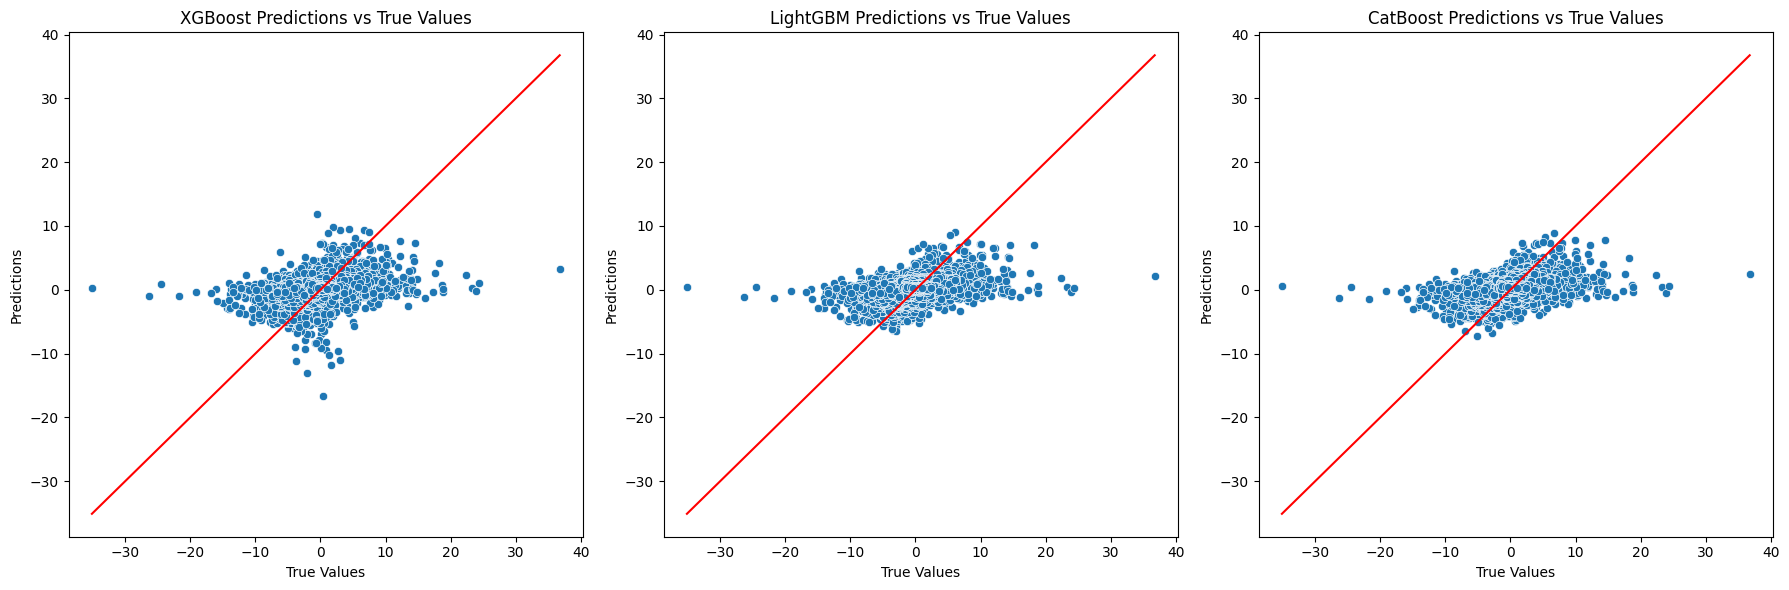

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns


xgb_results = pd.DataFrame({'True_Values': y_test, 'XGB_Predictions': xgb_predictions})
lgbm_results = pd.DataFrame({'True_Values': y_test, 'LGBM_Predictions': lgbm_predictions})
cat_results = pd.DataFrame({'True_Values': y_test, 'CatBoost_Predictions': cat_predictions})


plt.figure(figsize=(18, 6))


plt.subplot(1, 3, 1) 
sns.scatterplot(x='True_Values', y='XGB_Predictions', data=xgb_results)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red')
plt.title('XGBoost Predictions vs True Values')
plt.xlabel('True Values')
plt.ylabel('Predictions')


plt.subplot(1, 3, 2) 
sns.scatterplot(x='True_Values', y='LGBM_Predictions', data=lgbm_results)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red')
plt.title('LightGBM Predictions vs True Values')
plt.xlabel('True Values')
plt.ylabel('Predictions')


plt.subplot(1, 3, 3)
sns.scatterplot(x='True_Values', y='CatBoost_Predictions', data=cat_results)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red')
plt.title('CatBoost Predictions vs True Values')
plt.xlabel('True Values')
plt.ylabel('Predictions')

plt.tight_layout()
plt.show()
